In [1]:
import torch
print(torch.version.cuda)

12.4


## 1. Setup

In [5]:
import argparse
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add project root to sys.path
# project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
# project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), "..", ".."))
# sys.path.append(project_root)

from src.utils.config_utils import load_config, transfer_namespace
from src.data_factory import build_data
from src.model_factory import build_model
from plot.A1_plot_config import configure_matplotlib
from src.utils.masking import add_mask

### args

In [38]:
parser = argparse.ArgumentParser(description="Visualize pretraining prediction results.")
parser.add_argument('--config_path', type=str,
                        default='/home/lq/LQcode/2_project/PHMBench/PHM-Vibench/script/LQ1/Pretraining/Pretraining_C+P_patchtst.yaml',
                        help='Path to the pretraining configuration file.')
parser.add_argument('--ckpt_path', type=str,
                        # default= '/home/lq/LQcode/2_project/PHMBench/PHM-Vibench/save/metadata_6_11.xlsx/M_M_01_ISFM/T_pretrainmultitask_20_193514/iter_0/model-epoch=66-val_loss=0.0382.ckpt',
                        default='/home/lq/LQcode/2_project/PHMBench/PHM-Vibench/save/metadata_6_11.xlsx/M_M_01_ISFM/T_pretrainmultitask_20_213351/iter_0/model-epoch=23-val_loss=0.3714.ckpt',
                        help='Path to the pretrained model checkpoint.')
parser.add_argument('--file_ids', nargs='+',
                        default='10', help='List of file_ids to plot.')
args = parser.parse_args()



## 2 functions

In [39]:
def setup_pipeline(config_path, ckpt_path=None):
    """Loads configurations and sets up the environment."""
    print(f"加载配置文件: {config_path}")
    if ckpt_path:
        print(f"加载预训练模型: {ckpt_path}")
    
    configure_matplotlib(style='no-latex', font_lang='en') # ieee no-latex

    configs = load_config(config_path)
    args_data = transfer_namespace(configs.get('data', {}))
    args_model = transfer_namespace(configs.get('model', {}))
    args_task = transfer_namespace(configs.get('task', {}))
    
    if args_task.name == 'Multitask':
        args_data.task_list = args_task.task_list
        args_model.task_list = args_task.task_list

    if ckpt_path:
        args_model.weights_path = ckpt_path
        
    return args_data, args_model, args_task

def prepare_data_and_model(args_data, args_model, args_task):
    """Prepares dataset and model."""
    data_factory = build_data(args_data, args_task)
    metadata = data_factory.get_metadata()
    model = build_model(args_model, metadata)
    model.eval()
    dataset = data_factory.get_dataset('train')
    return dataset, model

def run_prediction(model, signal, file_id, args_task):
    """Runs prediction on a batch of data."""

    # 4. 执行预测任务并复现掩码逻辑
    x_in, total_mask = add_mask(signal, args_task.forecast_part, args_task.mask_ratio)

    with torch.no_grad():
        x_hat = model(x_in, file_id, task_id='prediction')
        
    return signal, x_in, x_hat, total_mask

def plot_results(signal, masked_signal, predicted_signal,
                  mask, save_path, sample_idx=0, channel_to_plot=0):
    """Visualizes and saves the prediction results."""
    L = signal.shape[1]
    signal_to_plot = signal[sample_idx, :, channel_to_plot].cpu().numpy()
    masked_to_plot = masked_signal[sample_idx, :, channel_to_plot].cpu().numpy()
    predicted_to_plot = predicted_signal[sample_idx, :, channel_to_plot].cpu().numpy()
    mask_to_plot = mask[sample_idx, :, channel_to_plot].cpu().numpy()
    timesteps = np.arange(L)

    fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
    fig.suptitle(f'Prediction Visualization (Sample {sample_idx}, Channel {channel_to_plot})')

    # 子图1: Ground Truth
    axes[0].plot(timesteps, signal_to_plot, label='Ground Truth')
    axes[0].fill_between(timesteps, signal_to_plot.min(), signal_to_plot.max(), where=mask_to_plot, color='gray', alpha=0.2, label='Masked Region')
    axes[0].set_title('Subfig 1: Ground Truth Signal')
    axes[0].legend()
    axes[0].grid(True)

    # 子图2: Masked Input
    axes[1].plot(timesteps, masked_to_plot, label='Masked Input')
    axes[1].fill_between(timesteps, signal_to_plot.min(), signal_to_plot.max(), where=mask_to_plot, color='gray', alpha=0.5, label='Masked Region')
    axes[1].set_title('Subfig 2: Masked Input Signal')
    axes[1].legend()
    axes[1].grid(True)

    # 子图3: Predicted Signal
    axes[2].plot(timesteps, predicted_to_plot, label='Predicted Signal', color='orange')
    axes[2].fill_between(timesteps, signal_to_plot.min(), signal_to_plot.max(), where=mask_to_plot, color='gray', alpha=0.5, label='Masked Region')
    axes[2].set_title('Subfig 3: Predicted Signal')
    axes[2].legend()
    axes[2].grid(True)

    # 子图4: Absolute Error
    abs_error = np.abs(signal_to_plot - predicted_to_plot)
    axes[3].plot(timesteps, abs_error, label='Absolute Error', color='red')
    axes[3].fill_between(timesteps, 0, abs_error.max(), where=mask_to_plot, color='gray', alpha=0.5, label='Masked Region')
    axes[3].set_title('Subfig 4: Absolute Error (Ground Truth vs. Prediction)')
    axes[3].set_xlabel('Time Step')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path + '.png', dpi=300)
    plt.savefig(save_path + '.pdf', dpi=300)
    print(f"Plot saved to {save_path}")
    plt.show()

def plot_pipeline(args):
    """Run the plot pipeline."""
    args_data, args_model, args_task = setup_pipeline(args.config_path, args.ckpt_path)
    dataset, model = prepare_data_and_model(args_data, args_model, args_task)
    
    if args.file_ids:
        if isinstance(args.file_ids, str):
            # If a single file_id is provided as a string, convert it to a list
            args.file_ids = [args.file_ids]
        elif isinstance(args.file_ids, list):
            file_ids_to_plot = args.file_ids
    else:
        # Default to plotting the first 5 available file_ids
        all_file_ids = list(dataset.dataset_dict.keys())
        file_ids_to_plot = all_file_ids[:min(5, len(all_file_ids))]

    print(f"Will generate plots for file_ids: {file_ids_to_plot}")

    for file_id in file_ids_to_plot:
        # The keys in dataset_dict might be integers, so we try to convert
        try:
            key = int(file_id)
        except ValueError:
            key = file_id

        original_dataset = dataset.dataset_dict.get(key)
        if original_dataset is None or len(original_dataset) == 0:
            print(f"Warning: No data for file_id {file_id}. Skipping.")
            continue

        # Get the first sample from this original dataset
        sample_dict = original_dataset[0]
        signal = sample_dict['x']# . # .unsqueeze(0)  # Shape: (1, L, C)
        signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)  # Ensure it's a tensor with shape (1, L, C)
        # Run prediction
        original_signal, x_in, x_hat, total_mask = run_prediction(model, signal, key, args_task)
        
        # Define save path for the plot
        plot_dir = os.path.join(project_root, 'plot', 'output')
        save_path = os.path.join(plot_dir, f'pretraining_prediction_fid_{file_id}')
        
        print(f"Plotting for file_id: {file_id}")
        plot_results(original_signal, x_in, x_hat, total_mask, save_path)

## 3 run

In [40]:

"""Run the plot pipeline."""
args_data, args_model, args_task = setup_pipeline(args.config_path, args.ckpt_path)
dataset, model = prepare_data_and_model(args_data, args_model, args_task)



加载配置文件: /home/lq/LQcode/2_project/PHMBench/PHM-Vibench/script/LQ1/Pretraining/Pretraining_C+P_patchtst.yaml
加载预训练模型: /home/lq/LQcode/2_project/PHMBench/PHM-Vibench/save/metadata_6_11.xlsx/M_M_01_ISFM/T_pretrainmultitask_20_213351/iter_0/model-epoch=23-val_loss=0.3714.ckpt
/home/lq/LQcode/2_project/PHMBench/PHM-Vibench
[INFO] 检查缓存文件: 数据文件已存在: /mnt/crucial/LQ/PHM-Vibench/metadata_6_11.xlsx 
[SUCCESS] 成功加载元数据，共 49867 条记录
筛选前元数据行数: 49867
筛选后元数据行数: 309
检查并准备各 Name.h5 缓存文件...


检查 Name.h5 缓存: 100%|██████████| 309/309 [00:00<00:00, 5120.24it/s]


正在将数据整合到任务缓存文件: /mnt/crucial/LQ/PHM-Vibench/cache.h5 ...


检查 cache.h5 是否已存在: 100%|██████████| 309/309 [00:00<00:00, 115521.88it/s]


数据整合完成。最终缓存文件: /mnt/crucial/LQ/PHM-Vibench/cache.h5
Using default task.
Initializing training and validation datasets...


Creating train/val datasets: 100%|██████████| 309/309 [00:10<00:00, 28.13it/s]


Initializing test datasets...


Creating test datasets: 100%|██████████| 309/309 [00:06<00:00, 50.28it/s]


成功导入模型模块: M_01_ISFM
跳过以下不匹配的参数：
  epoch: checkpoint vs model not in model
  global_step: checkpoint vs model not in model
  pytorch-lightning_version: checkpoint vs model not in model
  state_dict: checkpoint vs model not in model
  loops: checkpoint vs model not in model
  callbacks: checkpoint vs model not in model
  optimizer_states: checkpoint vs model not in model
  lr_schedulers: checkpoint vs model not in model
  hparams_name: checkpoint vs model not in model
  hyper_parameters: checkpoint vs model not in model
已加载匹配的权重: /home/lq/LQcode/2_project/PHMBench/PHM-Vibench/save/metadata_6_11.xlsx/M_M_01_ISFM/T_pretrainmultitask_20_213351/iter_0/model-epoch=23-val_loss=0.3714.ckpt
加载权重成功: /home/lq/LQcode/2_project/PHMBench/PHM-Vibench/save/metadata_6_11.xlsx/M_M_01_ISFM/T_pretrainmultitask_20_213351/iter_0/model-epoch=23-val_loss=0.3714.ckpt


In [43]:
offset =1 

file_ids = list(range(offset+2, offset+6))
if file_ids:
    if isinstance(file_ids, str):
        # If a single file_id is provided as a string, convert it to a list
        file_ids = [file_ids]
    # elif isinstance(file_ids, list):
    file_ids_to_plot = file_ids
else:
    # Default to plotting the first 5 available file_ids
    all_file_ids = list(dataset.dataset_dict.keys())
    file_ids_to_plot = all_file_ids[:min(5, len(all_file_ids))]

print(f"Will generate plots for file_ids: {file_ids_to_plot}")



Will generate plots for file_ids: [3, 4, 5, 6]


Plotting for file_id: 3


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Plot saved to plot/output/pretraining_prediction_fid_3


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

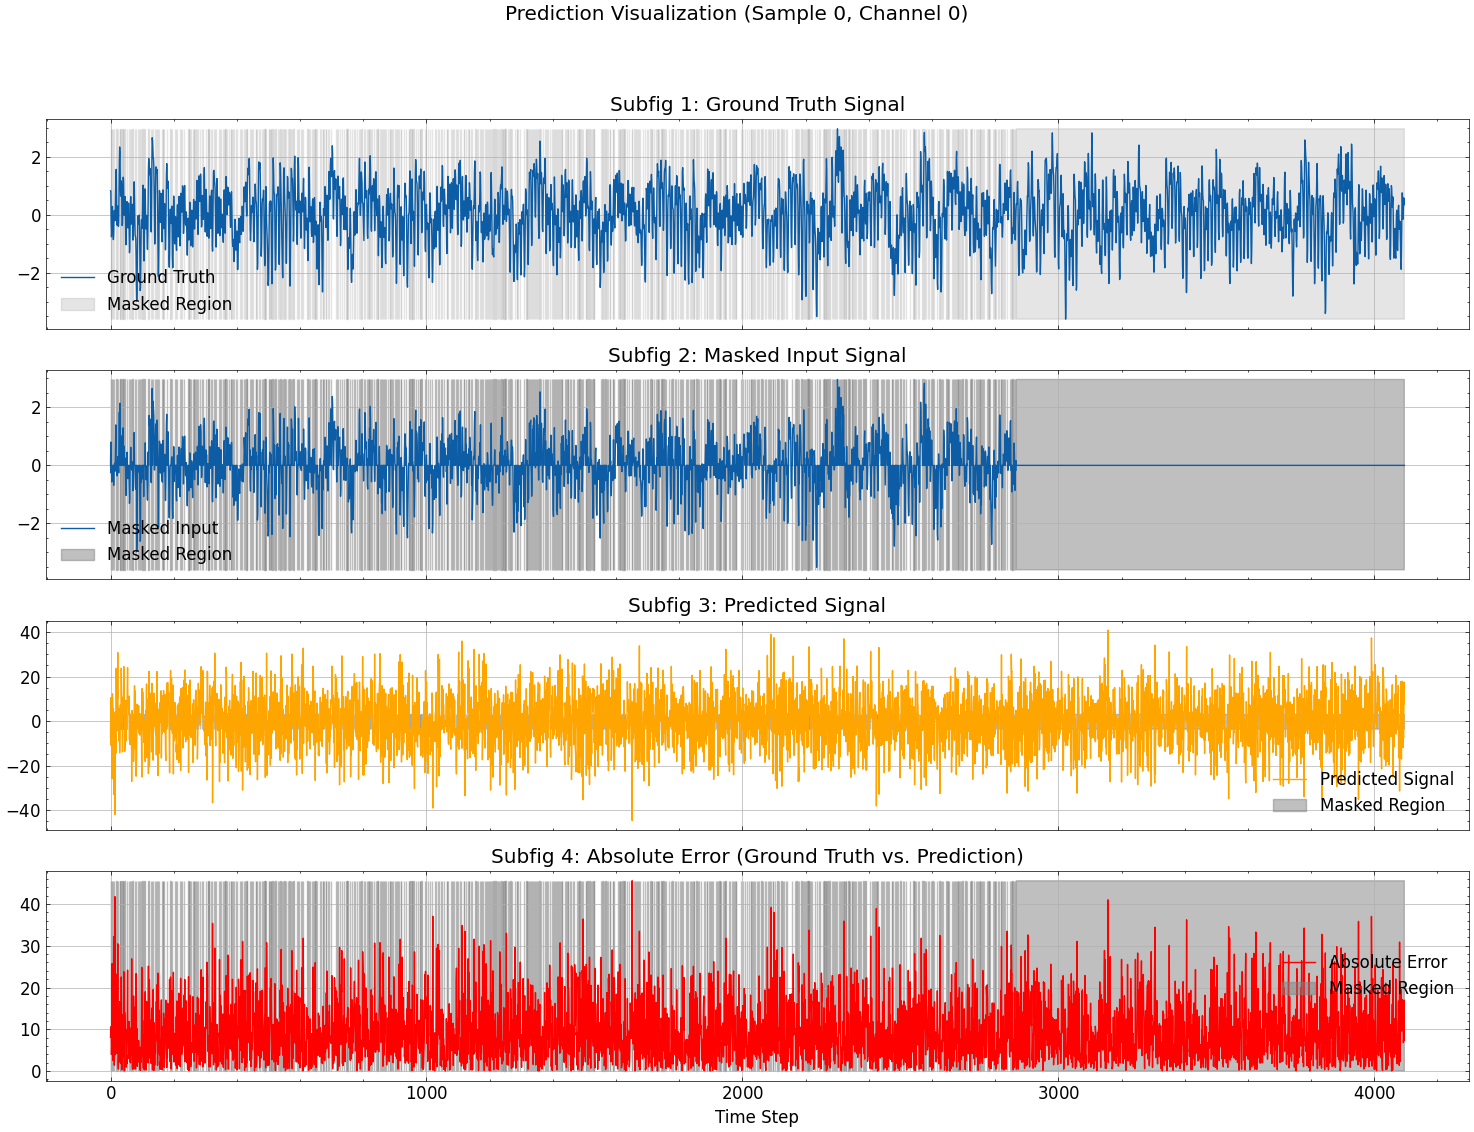

findfont: Font family 'Times New Roman' not found.


Plotting for file_id: 4


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Plot saved to plot/output/pretraining_prediction_fid_4


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

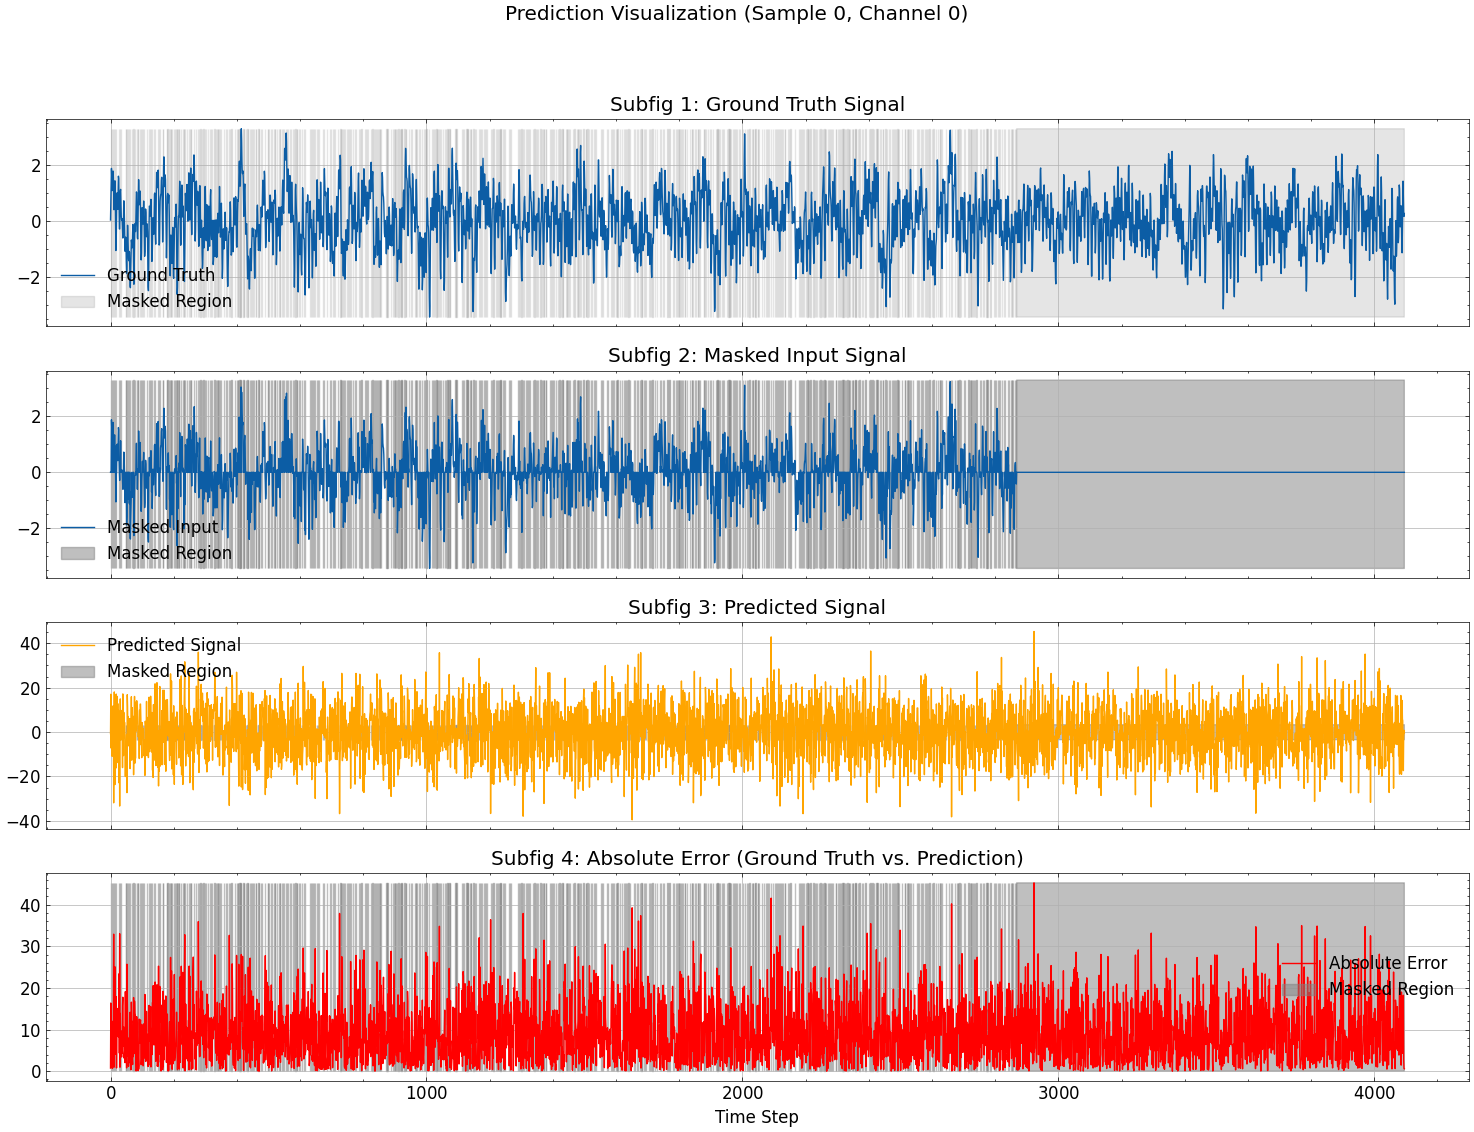

Plotting for file_id: 5


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Plot saved to plot/output/pretraining_prediction_fid_5


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

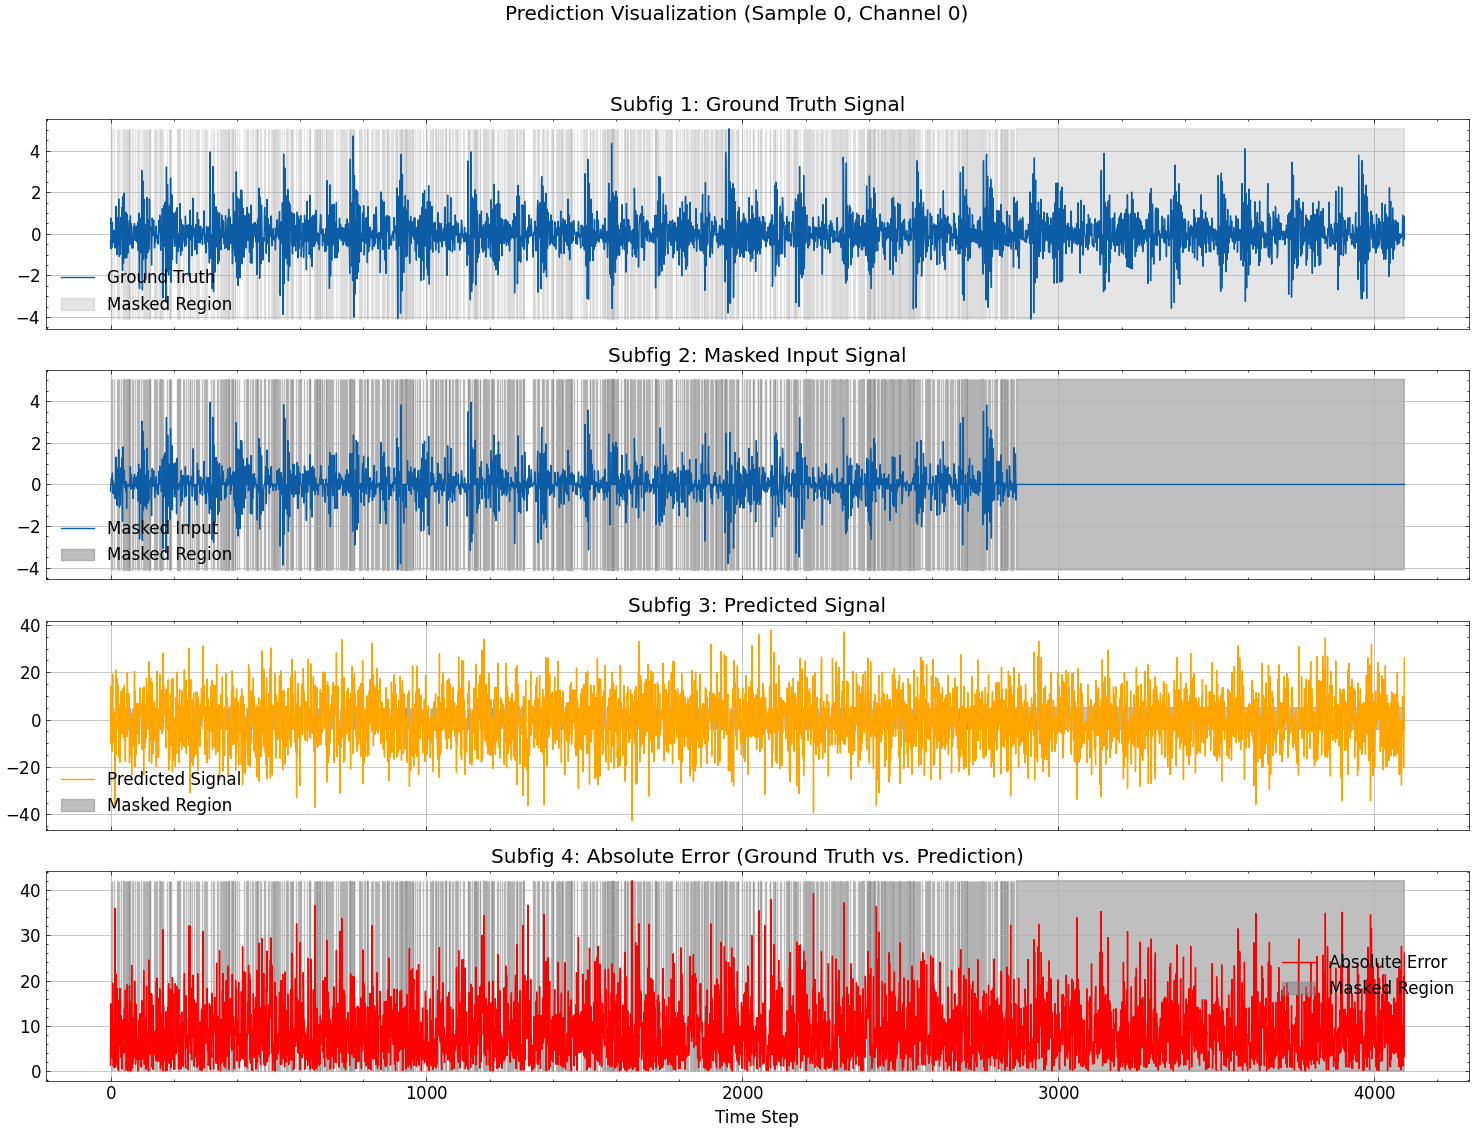

findfont: Font family 'Times New Roman' not found.


Plotting for file_id: 6


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Plot saved to plot/output/pretraining_prediction_fid_6


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

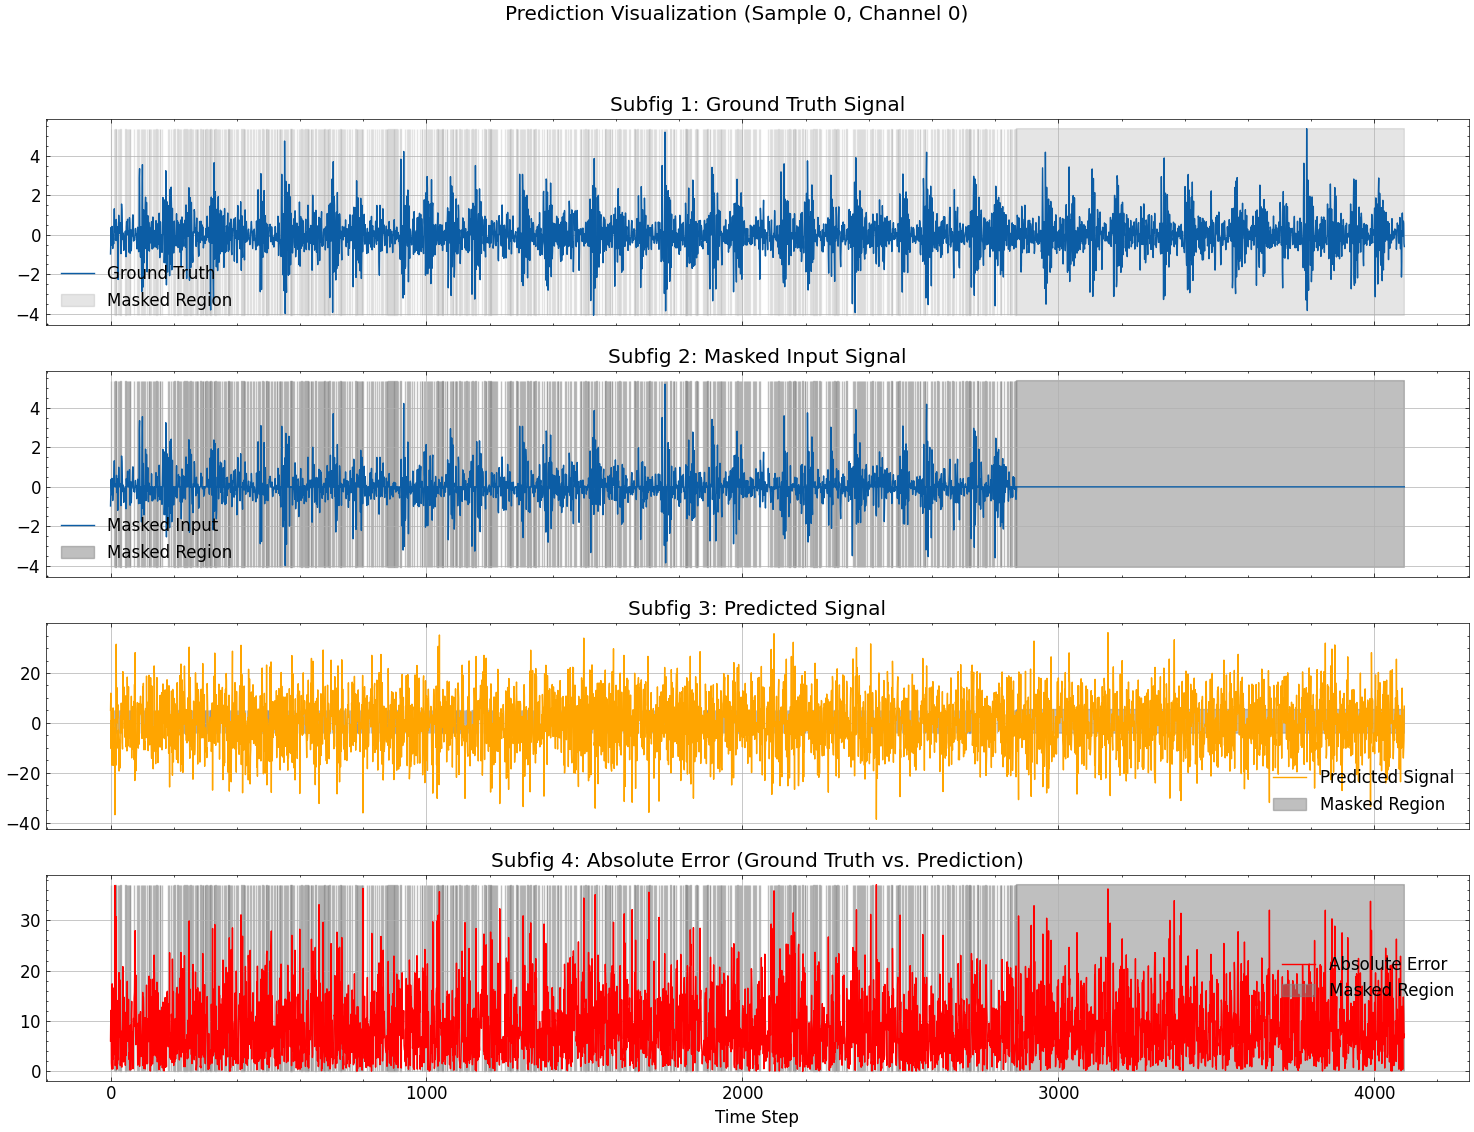

In [44]:
for file_id in file_ids_to_plot:
    # The keys in dataset_dict might be integers, so we try to convert
    try:
        key = int(file_id)
    except ValueError:
        key = file_id

    original_dataset = dataset.dataset_dict.get(key)
    if original_dataset is None or len(original_dataset) == 0:
        print(f"Warning: No data for file_id {file_id}. Skipping.")
        continue

    # Get the first sample from this original dataset
    sample_dict = original_dataset[0]
    signal = sample_dict['x']# . # .unsqueeze(0)  # Shape: (1, L, C)
    signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)  # Ensure it's a tensor with shape (1, L, C)
    # Run prediction
    original_signal, x_in, x_hat, total_mask = run_prediction(model, signal, key, args_task)
    
    # Define save path for the plot
    plot_dir = os.path.join('plot', 'output')
    save_path = os.path.join(plot_dir, f'pretraining_prediction_fid_{file_id}')
    
    print(f"Plotting for file_id: {file_id}")
    plot_results(original_signal, x_in, x_hat, total_mask, save_path)